In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Temporal Convolutional AE

#### Coarse grain experiment

In [ ]:
video = VideoLoader('data/experience/R25/R25_gray_scaled.mp4', duration=20, gray=True, randit=True)
num_epoch = 12
iteration_per_epoch = int(video.duration_frames/video.batch_size)

all_losses = {}
for nlayers in range(1, 6):
    for layerchans in [4, 8, 12]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = TemporalConvAE(1, nlayers, layerchans)
        optimizer = Adam(model.parameters())
        print(f'Model with {nlayers} layer with {layerchans} channels:')
        t1 = time()
        model(video.get_all_frames().view(iteration_per_epoch, 1, video.batch_size, video.height, video.width))
        print('Time to process the video:', f'{round(time()-t1, 2)}sec')
        
        losses = []
        t1 = time()
        for epoch in range(num_epoch):
            epoch_loss = 0
            for frames in video:
                frames = frames.view(-1, 1, video.batch_size, video.height, video.width)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            losses.append(epoch_loss / iteration_per_epoch)
            if (epoch+1) % 3 == 0:
                print(f'\t Error at epoch {epoch+1}:', losses[-1])
        
        all_losses[f'{nlayers},{layerchans}'] = (time()-t1, losses)

#### Colab

In [114]:
with open('all_losses_from_colab.json', 'r') as fp:
    all_losses = json.load(fp)
    
num_epoch = 30

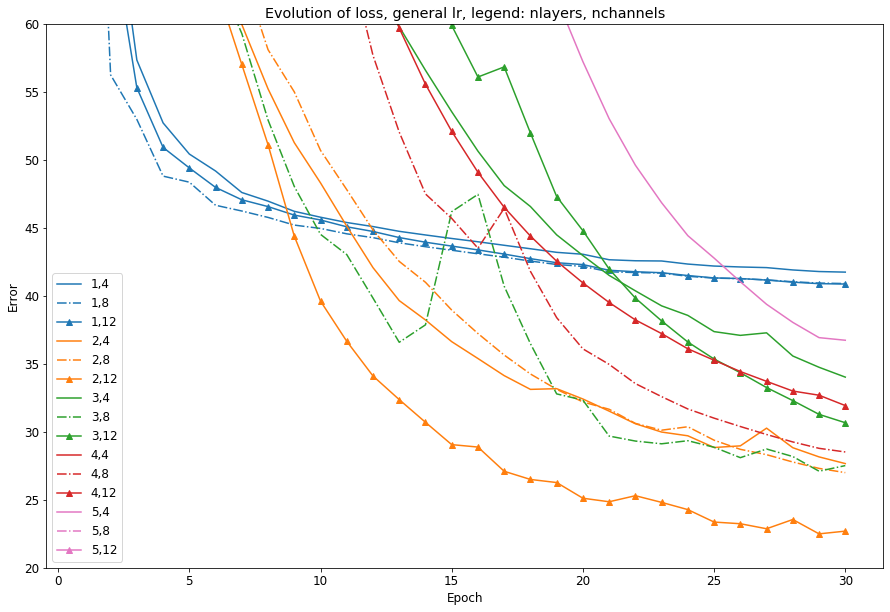

In [122]:
ys = [t[1] for t in all_losses.values()]
plot(range(1, num_epoch+1), ys, labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', 
     title='Evolution of loss, optimized lr, legend: nlayers,nchannels',
     styles=['C'+str(c)+'-'+s for c in [0,1,2,3,6] for s in ['','.','^']],
     yrange=(20, 60))

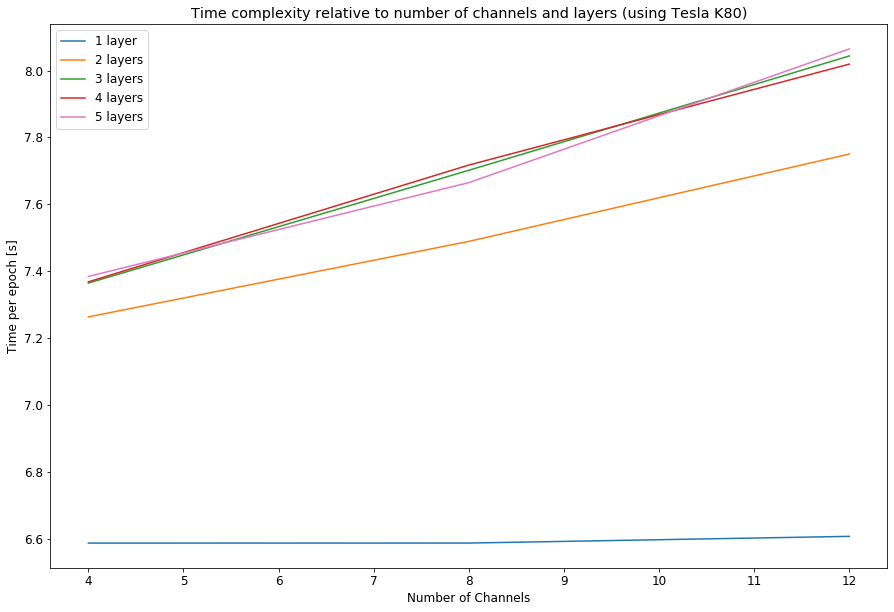

In [124]:
ys = [[time for (k, (time, _)) in all_losses.items() if k[0] == str(nlayers)]
      for nlayers in range(1, 6)]
labels = [f'{i} layers' for i in range(1, 6)]
labels[0] = labels[0][:-1]
plot([4, 8, 12], ys, labels=labels, title='Time complexity relative to number of channels and layers (using Tesla K80)', xlabel='Number of Channels', ylabel='Time per epoch [s]')

### Spatial Convolutionnal AE

In [ ]:
m = SpatialConvAE(1, 50)
m(torch.ones((10*60*25, 1, 256, 256)))

In [24]:
print(SpatialConvAE(1, ncomp))

SpatialConvAE(
  (encoder_convs): Sequential(
    (0): Conv2d(1, 128, kernel_size=(26, 26), stride=(5, 5))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(11, 11), stride=(3, 3))
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
    (5): ReLU()
  )
  (encoder_lin): Linear(in_features=4096, out_features=50, bias=True)
  (decoder_lin): Linear(in_features=50, out_features=4096, bias=True)
  (decoder_convs): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 128, kernel_size=(11, 11), stride=(3, 3))
    (3): ReLU()
    (4): ConvTranspose2d(128, 1, kernel_size=(26, 26), stride=(5, 5))
  )
)


#### Tuning hyperparameters

In [9]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [1e-5, 1e-3, 1e-1]:
    for wd in [0]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model3 = SpatialConvAE(1, ncomp)
        optimizer = Adam(model3.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model3.parameters()])}')
        
        losses = []
        for i in range(12):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model3(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 1e-05, wd -> 0, nparams -> 5142131
4 : 151.75733184814453
8 : 118.11524073282878
12 : 100.64645767211914
ncomp -> 50, lr -> 0.001, wd -> 0, nparams -> 5142131
4 : 72.58752695719402
8 : 31.690513610839844
12 : 25.71382999420166
ncomp -> 50, lr -> 0.1, wd -> 0, nparams -> 5142131
4 : 152.46471405029297
8 : 150.0633290608724
12 : 147.92462412516275


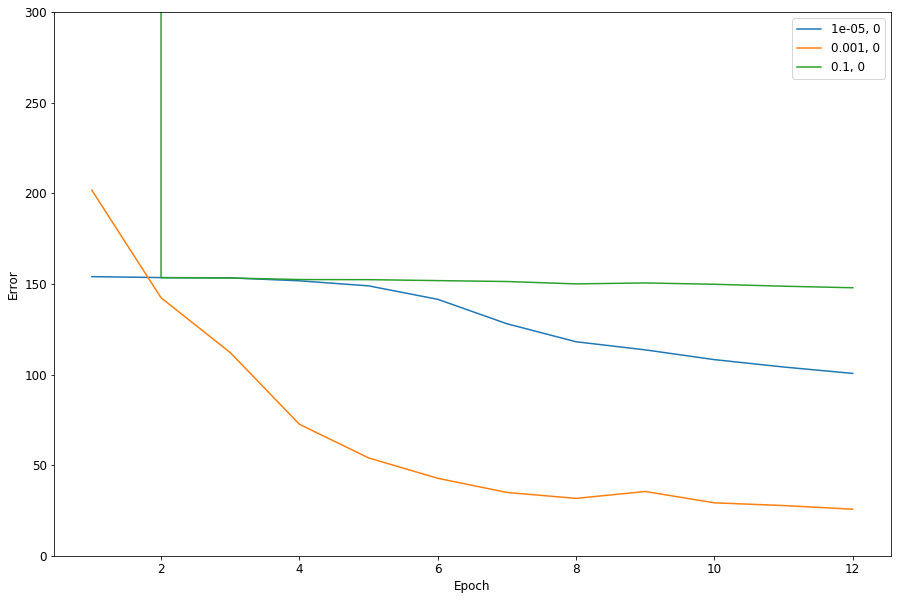

In [14]:
plot(range(1, 13), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', yrange=(0, 300))

#### Training

In [15]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

lr, wd = 1e-3, 0
num_epoch = 20

torch.manual_seed(seed)
np.random.seed(seed)

model3 = SpatialConvAE(1, ncomp)
optimizer = Adam(model3.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model3.parameters()])}')

losses = []
t1 = time()
for i in range(num_epoch):
    epoch_loss = 0
    nframe = 0
    for x in video:
        nframe += x.shape[0]
        x_reconstructed = model3(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
    losses.append(epoch_loss / nbatch)
t2 = time()

video.randit = video.skip_frame = 0

print('Fitting time:', sec2string(t2-t1))

t3 = time()
exact_loss = reconstruction_error(video.reduce_latent(model3, trans=False).numpy(), video.get_all_frames().squeeze().numpy())
t4 = time()
print('Transform time:', sec2string(t4-t3))

print('Reconstruction error:', exact_loss)

ncomp -> 50, lr -> 0.001, wd -> 0, nparams -> 5142131
Fitting time: 10:27
Transform time: 59.72
Reconstruction error: -1


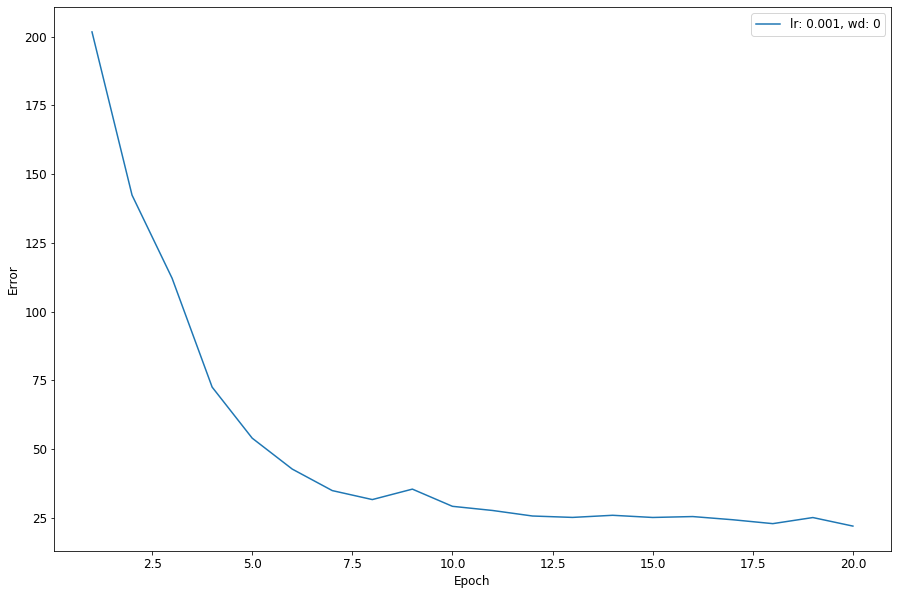

In [16]:
plot(range(1, num_epoch+1), [losses], labels=[f'lr: {lr}, wd: {wd}'], xlabel='Epoch', ylabel='Error')

# TRASH

In [26]:
import cv2
import numpy as np
# Create a VideoCapture object
cap = cv2.VideoCapture('data/experience/R25.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('data/out_transpose.mp4',cv2.VideoWriter_fourcc(*"MP4V"), 24, (frame_height//2,frame_width//2), 0)
while(True):
    ret, frame = cap.read()
    if ret == True: 
        frame = np.transpose(frame, axes=[1,0, 2])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Write the frame into the file 'output.avi'
        frame = cv2.resize(frame, (frame_height//2, frame_width//2), interpolation=cv2.INTER_AREA)
        out.write(frame)
    # Display the resulting frame
    # Press Q on keyboard to stop recording
  # Break the loop
    else:
        break 
# When everything done, release the video capture and video write objects
cap.release()
out.release()

In [17]:
cv2.destroyAllWindows()